In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Updated for scikit-learn 1.2+ (plot_roc_curve is deprecated)
from sklearn.metrics import RocCurveDisplay



In [2]:
df = pd.read_csv('heart-disease.csv')  # Note: filename has hyphen, not underscore
df.shape

(303, 14)

In [3]:
df["target"].value_counts()
df["target"].value_counts().plot(kind='bar', color=['salmon', 'lightblue']);


In [4]:
df["sex"].value_counts()

sex
1    207
0     96
Name: count, dtype: int64

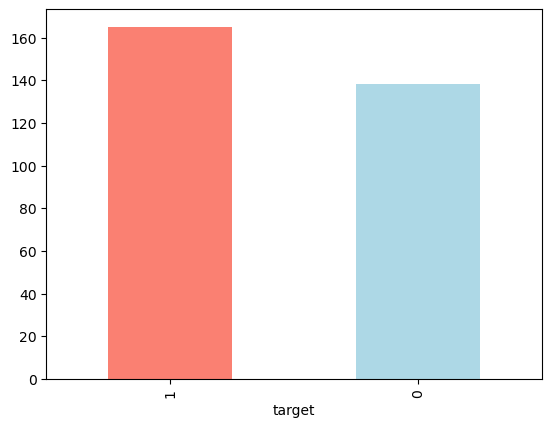

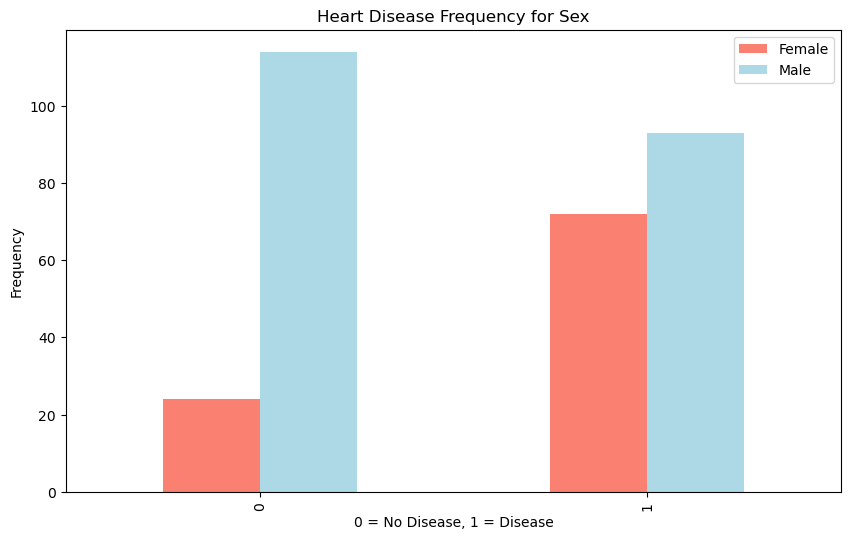

In [5]:
pd.crosstab(df.target, df.sex)
pd.crosstab(df.target, df.sex).plot(kind='bar',
                                    figsize=(10, 6),
                                    color=['salmon', 'lightblue'])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('0 = No Disease, 1 = Disease')
plt.ylabel('Frequency')
plt.legend(['Female', 'Male']);
plt.show()

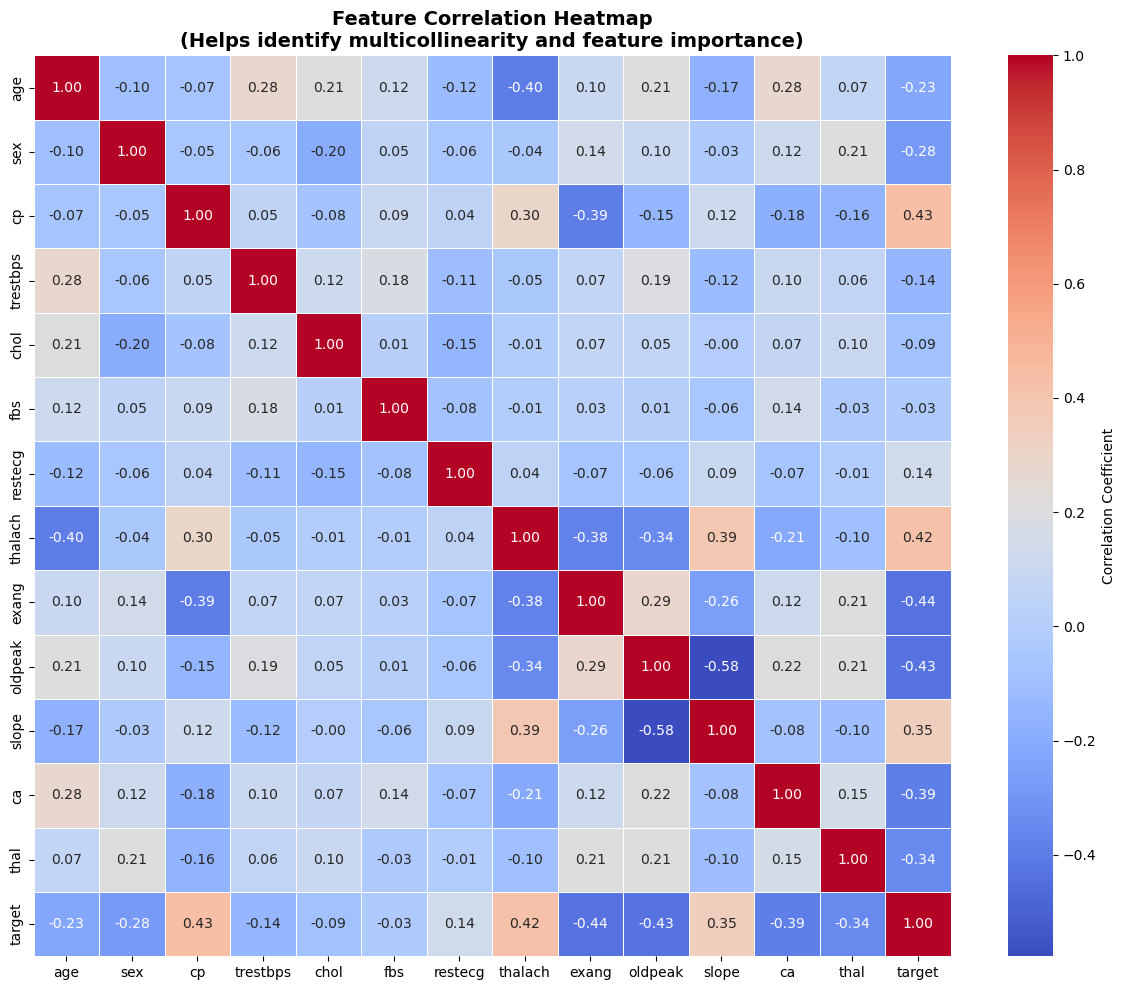

In [6]:
# Correlation Heatmap - Shows relationships between all features
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', 
            linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Feature Correlation Heatmap\n(Helps identify multicollinearity and feature importance)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


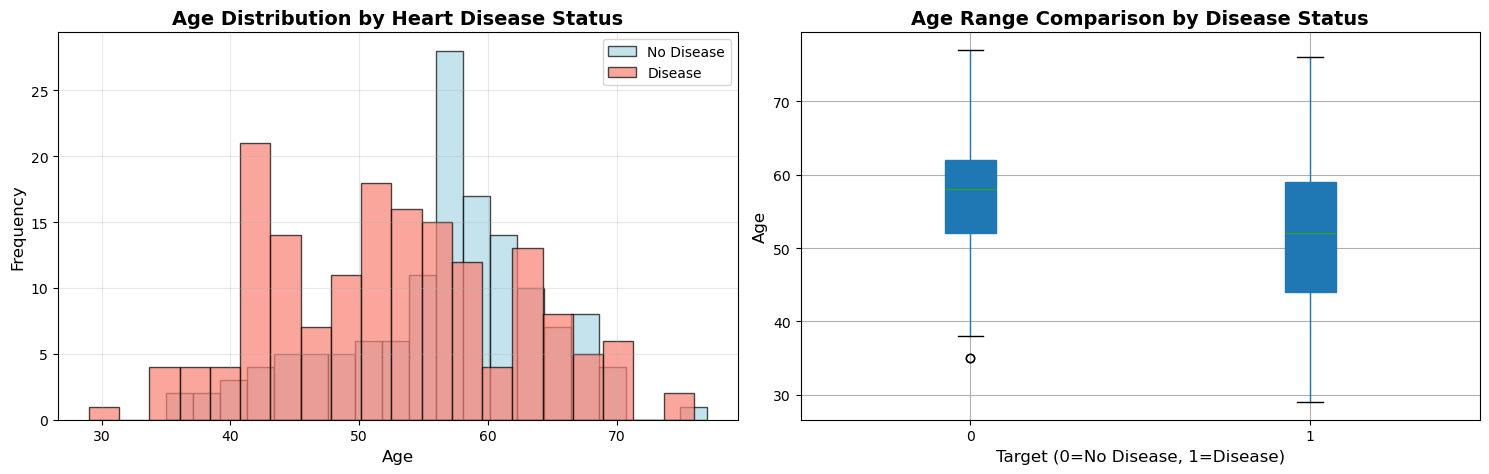


Age Statistics by Target:
        count       mean       std   min   25%   50%   75%   max
target                                                          
0       138.0  56.601449  7.962082  35.0  52.0  58.0  62.0  77.0
1       165.0  52.496970  9.550651  29.0  44.0  52.0  59.0  76.0


In [7]:
# Age Distribution Analysis - Compare age patterns between healthy and disease groups
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df[df['target'] == 0]['age'], bins=20, alpha=0.7, label='No Disease', color='lightblue', edgecolor='black')
axes[0].hist(df[df['target'] == 1]['age'], bins=20, alpha=0.7, label='Disease', color='salmon', edgecolor='black')
axes[0].set_xlabel('Age', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Age Distribution by Heart Disease Status', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
df.boxplot(column='age', by='target', ax=axes[1], patch_artist=True)
axes[1].set_xlabel('Target (0=No Disease, 1=Disease)', fontsize=12)
axes[1].set_ylabel('Age', fontsize=12)
axes[1].set_title('Age Range Comparison by Disease Status', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

# Summary statistics
print("\nAge Statistics by Target:")
print(df.groupby('target')['age'].describe())


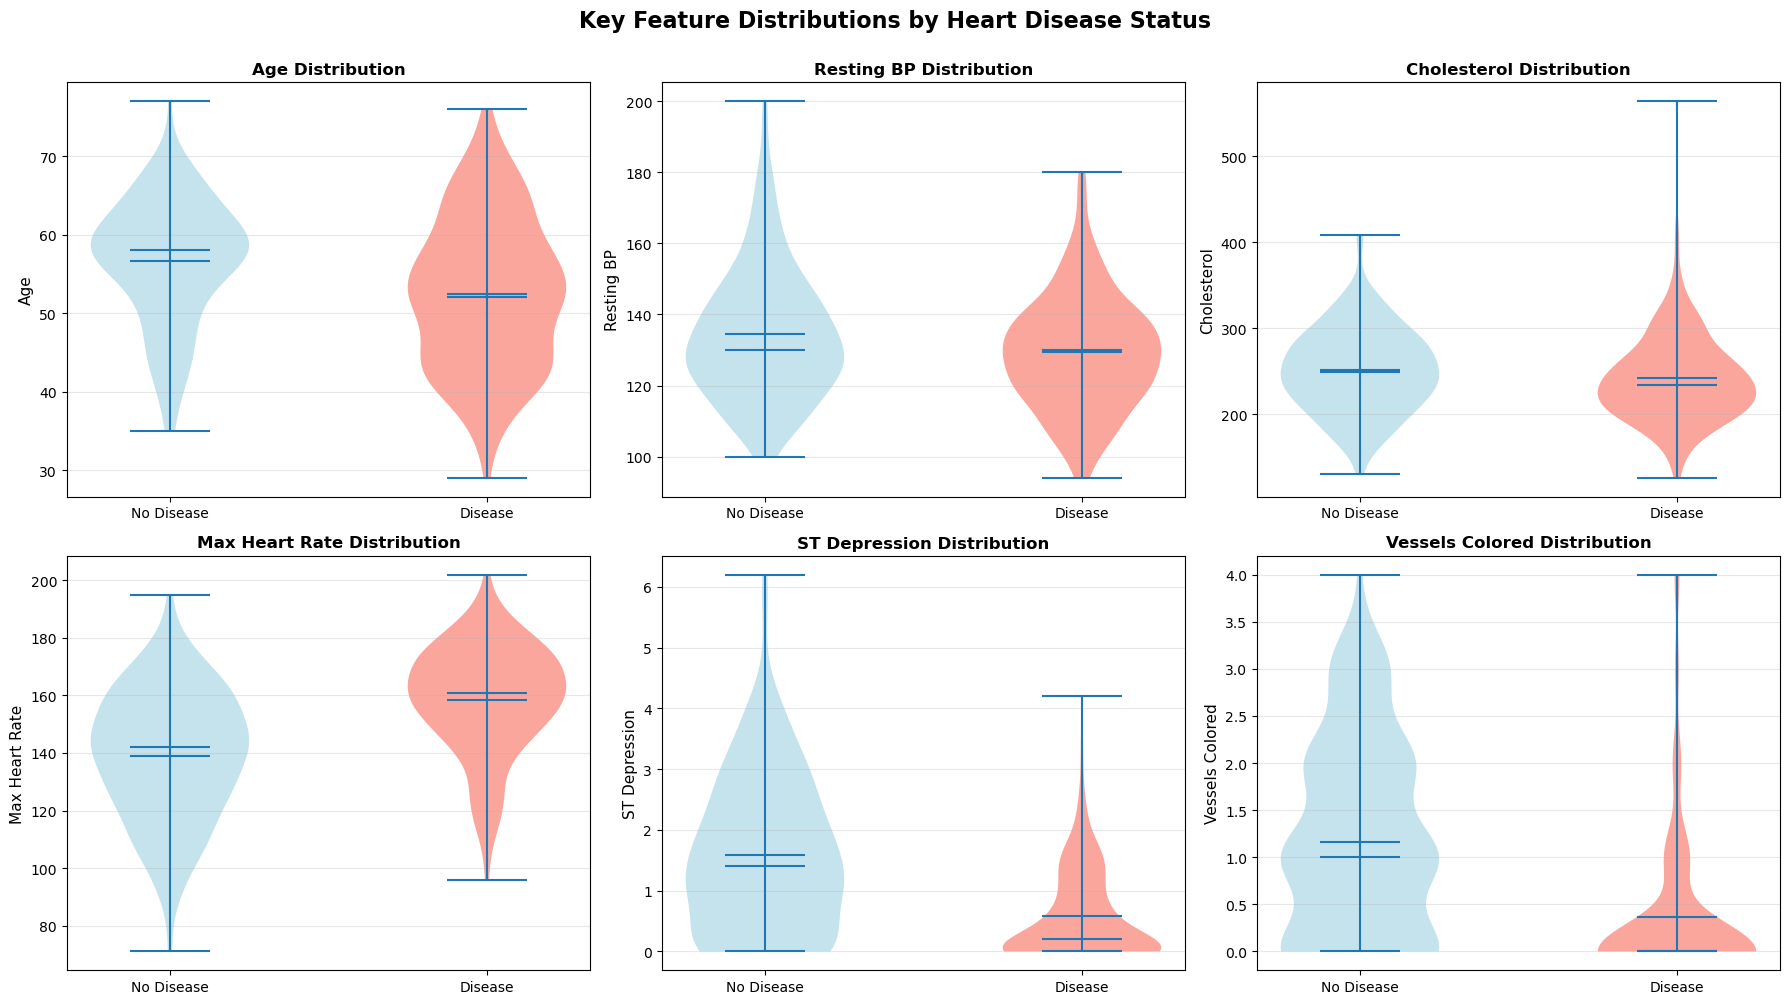

In [8]:
# Multiple Feature Distributions - Comprehensive view of key features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Key Feature Distributions by Heart Disease Status', fontsize=16, fontweight='bold', y=1.00)

# Features to plot
features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
feature_names = ['Age', 'Resting BP', 'Cholesterol', 'Max Heart Rate', 'ST Depression', 'Vessels Colored']

for idx, (feature, name) in enumerate(zip(features, feature_names)):
    row = idx // 3
    col = idx % 3
    
    # Violin plot for better distribution visualization
    parts = axes[row, col].violinplot(
        [df[df['target'] == 0][feature].dropna(), 
         df[df['target'] == 1][feature].dropna()],
        positions=[0, 1],
        showmeans=True,
        showmedians=True
    )
    
    # Color the violins
    colors = ['lightblue', 'salmon']
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    axes[row, col].set_xticks([0, 1])
    axes[row, col].set_xticklabels(['No Disease', 'Disease'])
    axes[row, col].set_ylabel(name, fontsize=11)
    axes[row, col].set_title(f'{name} Distribution', fontsize=12, fontweight='bold')
    axes[row, col].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


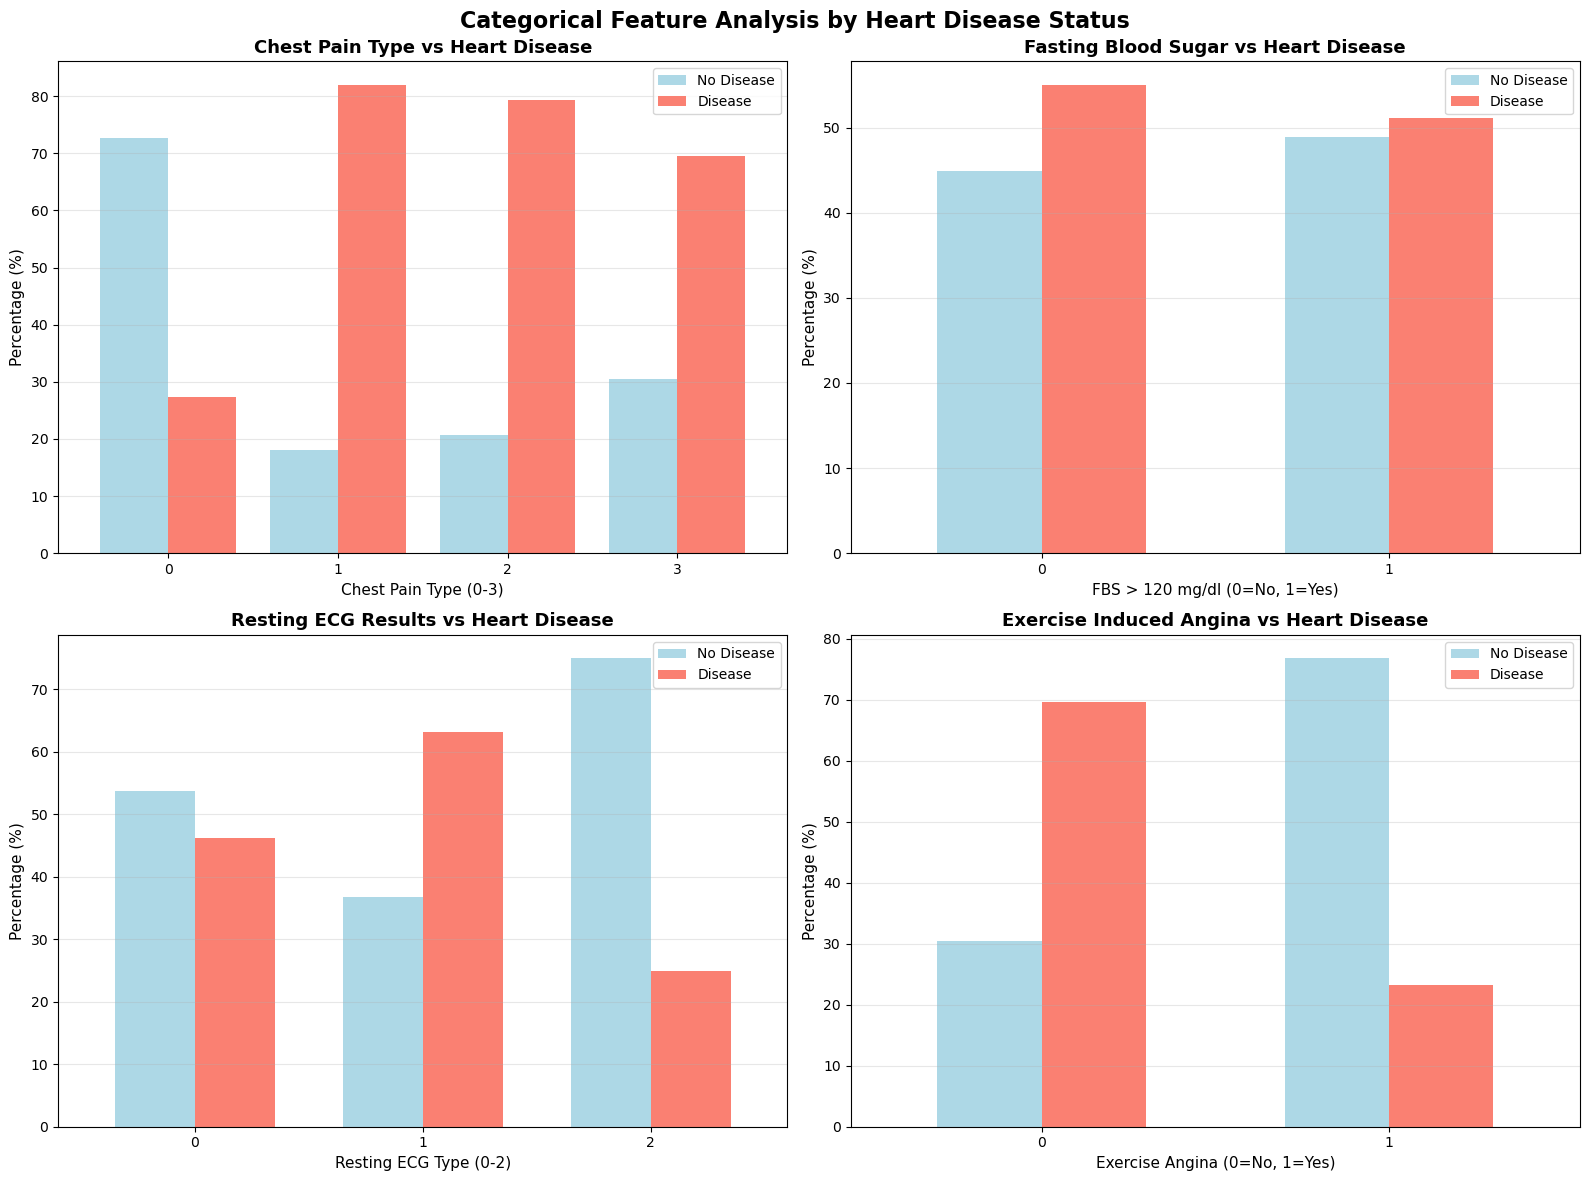


=== Categorical Feature Summary ===

Chest Pain Types Distribution:
cp
0    143
1     50
2     87
3     23
Name: count, dtype: int64

Exercise Induced Angina:
exang
0    204
1     99
Name: count, dtype: int64


In [9]:
# Categorical Features Analysis - Understanding patterns in categorical variables
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Categorical Feature Analysis by Heart Disease Status', fontsize=16, fontweight='bold')

# 1. Chest Pain Type (cp)
cp_crosstab = pd.crosstab(df['cp'], df['target'], normalize='index') * 100
cp_crosstab.plot(kind='bar', ax=axes[0, 0], color=['lightblue', 'salmon'], width=0.8)
axes[0, 0].set_title('Chest Pain Type vs Heart Disease', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Chest Pain Type (0-3)', fontsize=11)
axes[0, 0].set_ylabel('Percentage (%)', fontsize=11)
axes[0, 0].legend(['No Disease', 'Disease'], loc='upper right')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0)
axes[0, 0].grid(alpha=0.3, axis='y')

# 2. Fasting Blood Sugar (fbs)
fbs_crosstab = pd.crosstab(df['fbs'], df['target'], normalize='index') * 100
fbs_crosstab.plot(kind='bar', ax=axes[0, 1], color=['lightblue', 'salmon'], width=0.6)
axes[0, 1].set_title('Fasting Blood Sugar vs Heart Disease', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('FBS > 120 mg/dl (0=No, 1=Yes)', fontsize=11)
axes[0, 1].set_ylabel('Percentage (%)', fontsize=11)
axes[0, 1].legend(['No Disease', 'Disease'], loc='upper right')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Resting ECG (restecg)
restecg_crosstab = pd.crosstab(df['restecg'], df['target'], normalize='index') * 100
restecg_crosstab.plot(kind='bar', ax=axes[1, 0], color=['lightblue', 'salmon'], width=0.7)
axes[1, 0].set_title('Resting ECG Results vs Heart Disease', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Resting ECG Type (0-2)', fontsize=11)
axes[1, 0].set_ylabel('Percentage (%)', fontsize=11)
axes[1, 0].legend(['No Disease', 'Disease'], loc='upper right')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Exercise Induced Angina (exang)
exang_crosstab = pd.crosstab(df['exang'], df['target'], normalize='index') * 100
exang_crosstab.plot(kind='bar', ax=axes[1, 1], color=['lightblue', 'salmon'], width=0.6)
axes[1, 1].set_title('Exercise Induced Angina vs Heart Disease', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Exercise Angina (0=No, 1=Yes)', fontsize=11)
axes[1, 1].set_ylabel('Percentage (%)', fontsize=11)
axes[1, 1].legend(['No Disease', 'Disease'], loc='upper right')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Categorical Feature Summary ===")
print(f"\nChest Pain Types Distribution:\n{df['cp'].value_counts().sort_index()}")
print(f"\nExercise Induced Angina:\n{df['exang'].value_counts()}")


In [10]:
# Prepare data for modeling
# Separate features (X) and target (y)
X = df.drop('target', axis=1)
y = df['target']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFirst few rows of features:\n{X.head()}")


Features shape: (303, 13)
Target shape: (303,)

First few rows of features:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  
0   0     1  
1   0     2  
2   0     2  
3   0     2  
4   0     2  


In [11]:
# Split data into training and testing sets
# Using 80-20 split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Feature count: {X_train.shape[1]}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())


Training set size: 242 samples
Testing set size: 61 samples
Feature count: 13

Class distribution in training set:
target
1    133
0    109
Name: count, dtype: int64


In [12]:
# Train a Random Forest Classifier
# Initialize and train the model
np.random.seed(42)
rf_model = RandomForestClassifier(n_estimators=100, 
                                 random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions on test set
y_pred = rf_model.predict(X_test)

# Calculate and display accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Model Performance Metrics:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")


Model Performance Metrics:
Accuracy:  0.836
Precision: 0.844
Recall:    0.844
F1 Score:  0.844


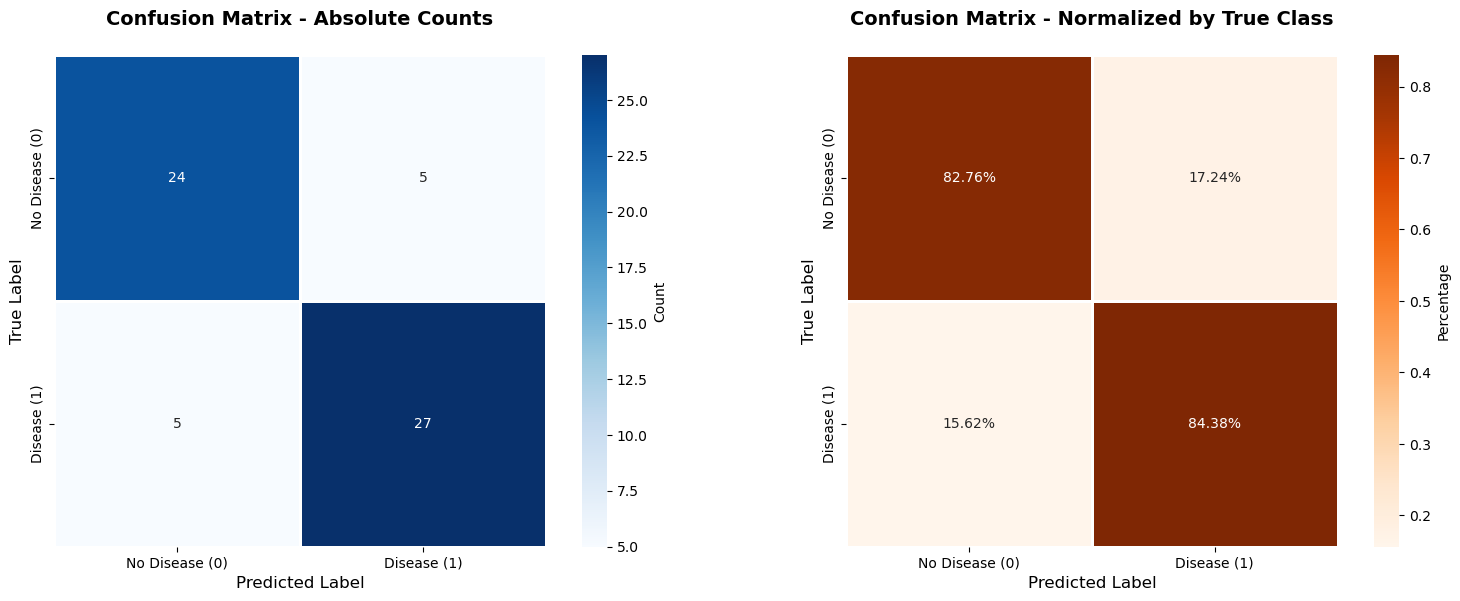


Detailed Classification Report:
              precision    recall  f1-score   support

  No Disease       0.83      0.83      0.83        29
     Disease       0.84      0.84      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61


Confusion Matrix Breakdown:
  True Negatives (TN):  24 - Correctly predicted No Disease
  False Positives (FP): 5 - Incorrectly predicted Disease
  False Negatives (FN): 5 - Incorrectly predicted No Disease
  True Positives (TP):  27 - Correctly predicted Disease


In [13]:
# Confusion Matrix Heatmap - Visualize model predictions
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a more detailed visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Absolute counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            cbar_kws={'label': 'Count'},
            linewidths=2, linecolor='white',
            ax=axes[0],
            square=True,
            cbar=True)
axes[0].set_title('Confusion Matrix - Absolute Counts\n', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xticklabels(['No Disease (0)', 'Disease (1)'])
axes[0].set_yticklabels(['No Disease (0)', 'Disease (1)'])

# Plot 2: Normalized (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Oranges',
            cbar_kws={'label': 'Percentage'},
            linewidths=2, linecolor='white',
            ax=axes[1],
            square=True,
            cbar=True)
axes[1].set_title('Confusion Matrix - Normalized by True Class\n', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xticklabels(['No Disease (0)', 'Disease (1)'])
axes[1].set_yticklabels(['No Disease (0)', 'Disease (1)'])

plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nDetailed Classification Report:")
print("=" * 60)
print(classification_report(y_test, y_pred, 
                          target_names=['No Disease', 'Disease']))
print("=" * 60)

# Interpretation
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives (TN):  {tn} - Correctly predicted No Disease")
print(f"  False Positives (FP): {fp} - Incorrectly predicted Disease")
print(f"  False Negatives (FN): {fn} - Incorrectly predicted No Disease")
print(f"  True Positives (TP):  {tp} - Correctly predicted Disease")


In [14]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [15]:
x = df.drop('target', axis=1)
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)



In [16]:
from sklearn.ensemble import RandomForestClassifier

classifier_model = RandomForestClassifier()
classifier_model.fit(x_train, y_train)

classifier_model.score(x_test, y_test)


0.8360655737704918

In [17]:
from sklearn.ensemble import RandomForestRegressor

regressor_model = RandomForestRegressor()
regressor_model.fit(x_train, y_train)

regressor_model.score(x_test, y_test)


0.5253306034482759

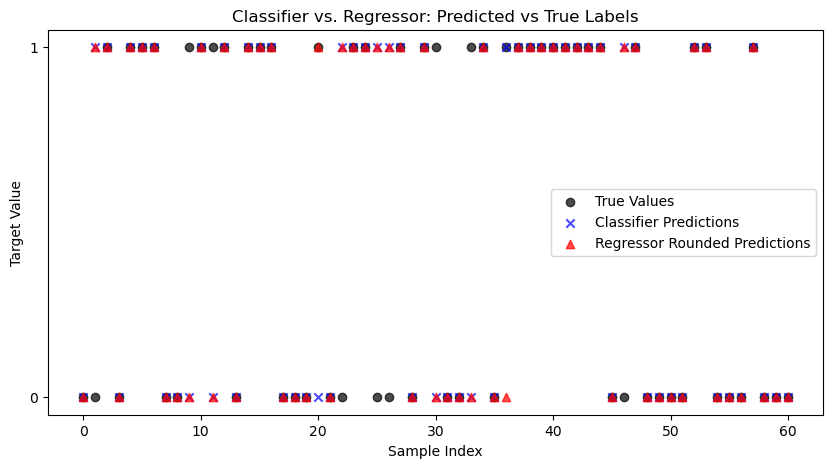

Classifier (RandomForestClassifier) Accuracy: 0.8360655737704918
Regressor (RandomForestRegressor, rounded) Accuracy: 0.8360655737704918


In [18]:
#plotting regressor model vs classifier model
import matplotlib.pyplot as plt
import numpy as np

# Get predictions from both models
y_pred_class = classifier_model.predict(x_test)
y_pred_reg = regressor_model.predict(x_test)

# If regressor output is not binary, round to 0 or 1
y_pred_reg_rounded = np.round(y_pred_reg)

# Scatter plot: True labels vs. predictions
plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test)), y_test, color='black', label="True Values", marker='o', alpha=0.7)
plt.scatter(range(len(y_test)), y_pred_class, color='blue', label="Classifier Predictions", marker='x', alpha=0.7)
plt.scatter(range(len(y_test)), y_pred_reg_rounded, color='red', label="Regressor Rounded Predictions", marker='^', alpha=0.7)
plt.title("Classifier vs. Regressor: Predicted vs True Labels")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.yticks([0,1])
plt.legend()
plt.show()

# Optional: Compare accuracy of both approaches on classification task
from sklearn.metrics import accuracy_score

acc_classifier = accuracy_score(y_test, y_pred_class)
acc_regressor = accuracy_score(y_test, y_pred_reg_rounded)

print("Classifier (RandomForestClassifier) Accuracy:", acc_classifier)
print("Regressor (RandomForestRegressor, rounded) Accuracy:", acc_regressor)


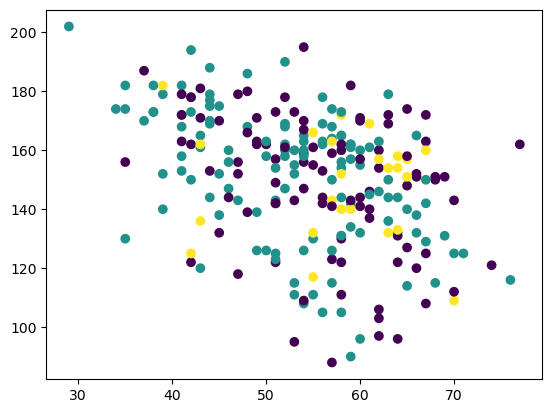

In [19]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(x_train)

plt.scatter(x_train['age'], x_train['thalach'], c=kmeans.labels_)
plt.show()


## ROC Curve Visualizations

ROC (Receiver Operating Characteristic) curves show the trade-off between True Positive Rate (Sensitivity) and False Positive Rate (1 - Specificity) at various classification thresholds.


In [ ]:
# Basic ROC Curve
from sklearn.metrics import roc_curve, auc

def plot_basic_roc_curve(y_true, y_proba, model_name="Model"):
    """
    Plot a basic ROC curve with AUC score.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'{model_name} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve - {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return roc_auc

# Get probability predictions
y_proba = best_rf_model.predict_proba(x_test)[:, 1]

# Plot basic ROC curve
basic_auc = plot_basic_roc_curve(y_test, y_proba, "Optimized Random Forest")


In [20]:
def compare_models(models, x_train, y_train):
    for model in models:
        model.fit(x_train, y_train)
        print(model.score(x_test, y_test))

compare_models([classifier_model, regressor_model, kmeans], x_train, y_train)

0.8360655737704918
0.5278350215517242
-102747.73200837422


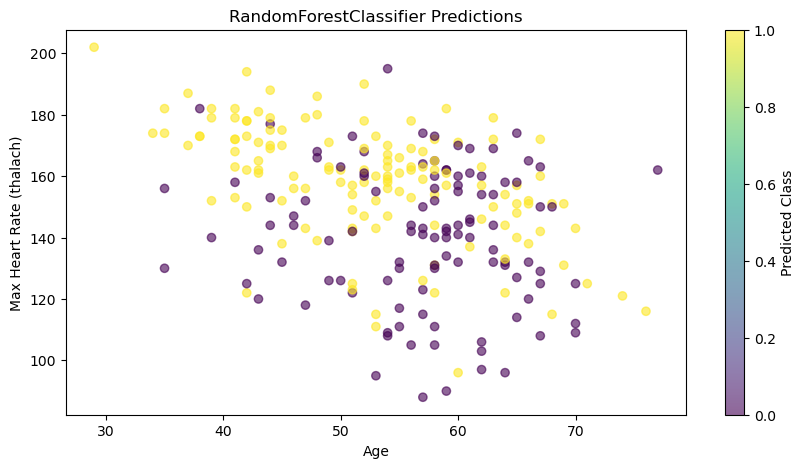

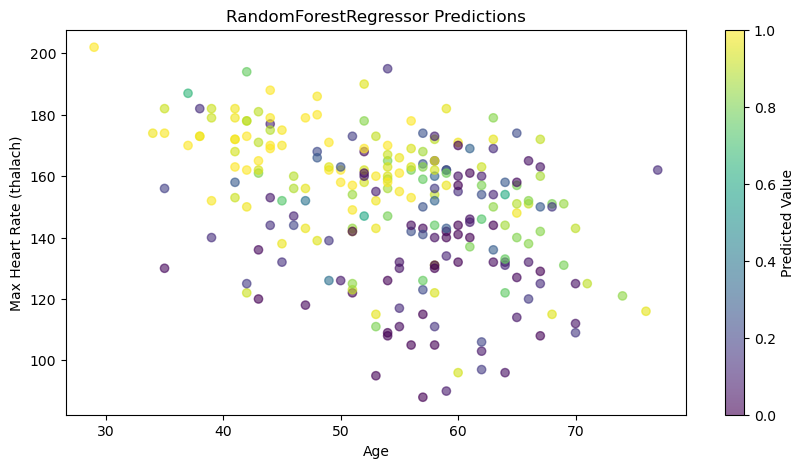

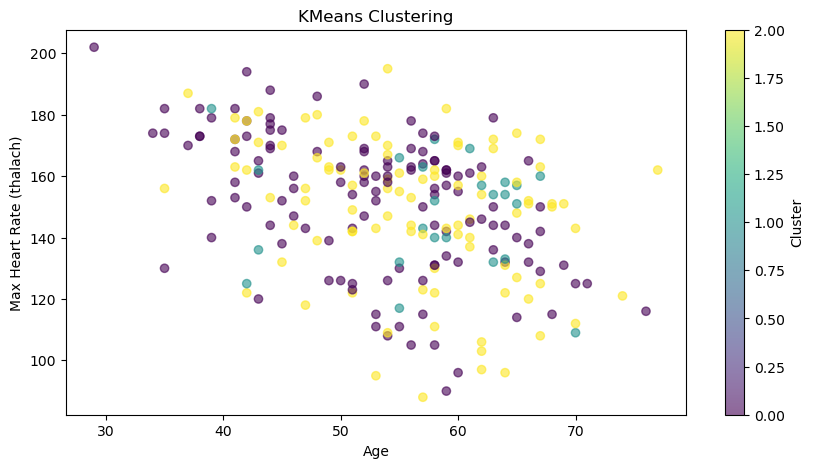

In [21]:
def plot_model_comparison(models, x_train, y_train):
    for model in models:
        model.fit(x_train, y_train)
        plt.figure(figsize=(10, 5))
        
        # Check if it's a clustering model (has labels_)
        if hasattr(model, 'labels_'):
            # For clustering models (like KMeans)
            colors = model.labels_
            title = f'{model.__class__.__name__} Clustering'
            colorbar_label = 'Cluster'
        else:
            # For classifiers and regressors (use predictions)
            colors = model.predict(x_train)
            if model.__class__.__name__ in ['RandomForestClassifier', 'LogisticRegression', 'KNeighborsClassifier']:
                title = f'{model.__class__.__name__} Predictions'
                colorbar_label = 'Predicted Class'
            else:
                title = f'{model.__class__.__name__} Predictions'
                colorbar_label = 'Predicted Value'
        
        plt.scatter(x_train['age'], x_train['thalach'], c=colors, cmap='viridis', alpha=0.6)
        plt.colorbar(label=colorbar_label)
        plt.xlabel('Age')
        plt.ylabel('Max Heart Rate (thalach)')
        plt.title(title)
        plt.show()

plot_model_comparison([classifier_model, regressor_model, kmeans], x_train, y_train)

In [22]:
def print_tuned_parameters(model):
    hyperparameters = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    for param in hyperparameters:
        model.set_params(n_estimators=param)
        model.fit(x_train, y_train)
        print(f"n_estimators: {param}, score: {model.score(x_test, y_test)}")

print_tuned_parameters(classifier_model)


n_estimators: 10, score: 0.7868852459016393
n_estimators: 20, score: 0.8032786885245902
n_estimators: 30, score: 0.8360655737704918
n_estimators: 40, score: 0.8360655737704918
n_estimators: 50, score: 0.8688524590163934
n_estimators: 60, score: 0.8360655737704918
n_estimators: 70, score: 0.8688524590163934
n_estimators: 80, score: 0.8360655737704918
n_estimators: 90, score: 0.8688524590163934
n_estimators: 100, score: 0.8524590163934426


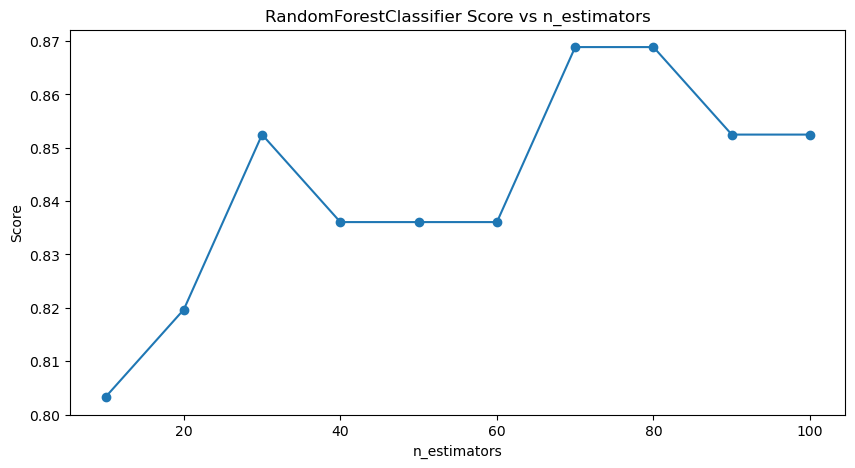

In [23]:
def plot_model_comparison_hyperparameters(model, x_train, y_train):
    hyperparameters = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    scores = []
    
    for param in hyperparameters:
        model.set_params(n_estimators=param)
        model.fit(x_train, y_train)
        scores.append(model.score(x_test, y_test))
    
    plt.figure(figsize=(10, 5))
    plt.plot(hyperparameters, scores, marker='o')
    plt.xlabel('n_estimators')
    plt.ylabel('Score')
    plt.title(f'{model.__class__.__name__} Score vs n_estimators')
    plt.show()
   
plot_model_comparison_hyperparameters(classifier_model, x_train, y_train)

In [24]:
from sklearn.model_selection import cross_val_score

def cross_val_score_per_hyperparameter(model, x_train, y_train):
    hyperparameters = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    scores = []
    for param in hyperparameters:
        model.set_params(n_estimators=param)
        scores.append(cross_val_score(model, x_train, y_train, cv=5).mean())
    return scores
cross_val_score_per_hyperparameter(classifier_model, x_train, y_train)

[np.float64(0.7768707482993198),
 np.float64(0.8060374149659865),
 np.float64(0.8262755102040817),
 np.float64(0.8017006802721088),
 np.float64(0.7976190476190477),
 np.float64(0.8140306122448979),
 np.float64(0.8222789115646257),
 np.float64(0.7975340136054421),
 np.float64(0.801530612244898),
 np.float64(0.8058673469387756)]

## Hyperparameter Tuning with RandomizedSearchCV

Now let's use RandomizedSearchCV to find the optimal hyperparameters more efficiently than GridSearchCV.


In [ ]:
# Define hyperparameter distributions for RandomizedSearchCV
from scipy.stats import randint, uniform

# Create a parameter distribution dictionary
param_distributions = {
    'n_estimators': randint(10, 200),           # Number of trees: 10-200
    'max_depth': [None, 10, 20, 30, 40, 50],    # Maximum depth of trees
    'min_samples_split': randint(2, 20),        # Minimum samples to split
    'min_samples_leaf': randint(1, 10),         # Minimum samples per leaf
    'max_features': ['sqrt', 'log2', None],     # Features to consider for split
    'bootstrap': [True, False],                  # Whether to use bootstrap samples
    'criterion': ['gini', 'entropy']            # Split quality measure
}

print("Parameter distributions for RandomizedSearchCV:")
for param, distribution in param_distributions.items():
    print(f"  {param}: {distribution}")


In [ ]:
# Perform RandomizedSearchCV
np.random.seed(42)

# Initialize base model
rf_base = RandomForestClassifier(random_state=42)

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=50,              # Number of parameter settings sampled
    cv=5,                   # 5-fold cross-validation
    scoring='accuracy',     # Optimization metric
    n_jobs=-1,             # Use all available cores
    verbose=1,             # Show progress
    random_state=42,
    return_train_score=True
)

# Fit RandomizedSearchCV
print("Starting RandomizedSearchCV...")
print("This may take a minute...\n")
random_search.fit(x_train, y_train)

print("\n✓ RandomizedSearchCV completed!")


In [ ]:
# Display best parameters and score
print("=" * 70)
print("BEST HYPERPARAMETERS FOUND:")
print("=" * 70)
for param, value in random_search.best_params_.items():
    print(f"  {param:20s}: {value}")

print("\n" + "=" * 70)
print(f"Best Cross-Validation Score: {random_search.best_score_:.4f}")
print("=" * 70)

# Get the best model
best_rf_model = random_search.best_estimator_

# Evaluate on test set
test_score = best_rf_model.score(x_test, y_test)
print(f"\nTest Set Score: {test_score:.4f}")
print(f"Improvement over baseline: {(test_score - 0.836)*100:.2f}%")


## Comprehensive Model Testing Functions

Let's create reusable functions to test and evaluate our models thoroughly.


In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """
    Comprehensive model evaluation function
    
    Parameters:
    -----------
    model : sklearn model object
        Trained model to evaluate
    X_train, X_test : array-like
        Training and testing features
    y_train, y_test : array-like
        Training and testing labels
    model_name : str
        Name of the model for display purposes
    
    Returns:
    --------
    dict : Dictionary containing all evaluation metrics
    """
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'model_name': model_name,
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'test_precision': precision_score(y_test, y_test_pred),
        'test_recall': recall_score(y_test, y_test_pred),
        'test_f1': f1_score(y_test, y_test_pred),
    }
    
    # Calculate overfitting indicator
    metrics['overfit_gap'] = metrics['train_accuracy'] - metrics['test_accuracy']
    
    # Display results
    print("=" * 70)
    print(f"MODEL EVALUATION: {model_name}")
    print("=" * 70)
    print(f"Training Accuracy:   {metrics['train_accuracy']:.4f}")
    print(f"Testing Accuracy:    {metrics['test_accuracy']:.4f}")
    print(f"Overfit Gap:         {metrics['overfit_gap']:.4f}")
    print("-" * 70)
    print(f"Precision:           {metrics['test_precision']:.4f}")
    print(f"Recall:              {metrics['test_recall']:.4f}")
    print(f"F1 Score:            {metrics['test_f1']:.4f}")
    print("=" * 70)
    
    return metrics

# Test the function with our best model
best_model_metrics = evaluate_model(
    best_rf_model, x_train, x_test, y_train, y_test, 
    model_name="Optimized Random Forest (RandomizedSearchCV)"
)


In [ ]:
def cross_validate_model(model, X, y, cv=5, model_name="Model"):
    """
    Perform cross-validation and display detailed results
    
    Parameters:
    -----------
    model : sklearn model object
        Model to cross-validate
    X, y : array-like
        Features and labels
    cv : int
        Number of cross-validation folds
    model_name : str
        Name of the model for display
    
    Returns:
    --------
    dict : Dictionary with cross-validation scores
    """
    print(f"\nPerforming {cv}-Fold Cross-Validation for {model_name}...")
    
    # Perform cross-validation with multiple metrics
    cv_scores = {
        'accuracy': cross_val_score(model, X, y, cv=cv, scoring='accuracy'),
        'precision': cross_val_score(model, X, y, cv=cv, scoring='precision'),
        'recall': cross_val_score(model, X, y, cv=cv, scoring='recall'),
        'f1': cross_val_score(model, X, y, cv=cv, scoring='f1')
    }
    
    # Display results
    print("\n" + "-" * 70)
    print("Cross-Validation Results:")
    print("-" * 70)
    for metric, scores in cv_scores.items():
        print(f"{metric.capitalize():12s}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
        print(f"              Individual folds: {[f'{s:.3f}' for s in scores]}")
    print("-" * 70)
    
    return cv_scores

# Cross-validate the optimized model
cv_results = cross_validate_model(
    best_rf_model, x_train, y_train, cv=5,
    model_name="Optimized Random Forest"
)


In [ ]:
def generate_classification_report_detailed(model, X_test, y_test, model_name="Model"):
    """
    Generate a detailed classification report with visual elements
    
    Parameters:
    -----------
    model : sklearn model object
        Trained model
    X_test, y_test : array-like
        Test features and labels
    model_name : str
        Name of the model for display
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Get confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                cbar_kws={'label': 'Count'},
                linewidths=2, linecolor='white',
                ax=axes[0], square=True)
    axes[0].set_title(f'{model_name}\nConfusion Matrix', 
                     fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].set_xticklabels(['No Disease (0)', 'Disease (1)'])
    axes[0].set_yticklabels(['No Disease (0)', 'Disease (1)'])
    
    # Normalized Confusion Matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
                cbar_kws={'label': 'Percentage'},
                linewidths=2, linecolor='white',
                ax=axes[1], square=True)
    axes[1].set_title(f'{model_name}\nNormalized Confusion Matrix', 
                     fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Predicted Label', fontsize=12)
    axes[1].set_ylabel('True Label', fontsize=12)
    axes[1].set_xticklabels(['No Disease (0)', 'Disease (1)'])
    axes[1].set_yticklabels(['No Disease (0)', 'Disease (1)'])
    
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\n" + "=" * 70)
    print(f"CLASSIFICATION REPORT: {model_name}")
    print("=" * 70)
    print(classification_report(y_test, y_pred, 
                              target_names=['No Disease', 'Disease']))
    print("=" * 70)

# Generate detailed report for optimized model
generate_classification_report_detailed(
    best_rf_model, x_test, y_test,
    model_name="Optimized Random Forest"
)


## Model Comparison: Baseline vs Optimized

Let's compare different models to see the improvement from hyperparameter tuning.


In [ ]:
# Create and train multiple models for comparison
print("Training multiple models for comparison...\n")

# 1. Baseline Random Forest (default parameters)
rf_baseline = RandomForestClassifier(random_state=42)
rf_baseline.fit(x_train, y_train)

# 2. Manually tuned Random Forest
rf_manual = RandomForestClassifier(n_estimators=50, random_state=42)
rf_manual.fit(x_train, y_train)

# 3. Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(x_train, y_train)

# 4. K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train, y_train)

print("✓ All models trained successfully!")


In [ ]:
# Evaluate all models
models_to_compare = [
    (rf_baseline, "Random Forest (Baseline)"),
    (rf_manual, "Random Forest (Manual: n=50)"),
    (best_rf_model, "Random Forest (RandomizedSearchCV)"),
    (lr_model, "Logistic Regression"),
    (knn_model, "K-Nearest Neighbors")
]

# Store metrics for comparison
comparison_results = []

for model, name in models_to_compare:
    metrics = evaluate_model(model, x_train, x_test, y_train, y_test, model_name=name)
    comparison_results.append(metrics)
    print("\n")


In [ ]:
# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.set_index('model_name')

print("\n" + "=" * 90)
print("MODEL COMPARISON SUMMARY")
print("=" * 90)
print(comparison_df.round(4))
print("=" * 90)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# Plot 1: Test Accuracy
ax1 = axes[0, 0]
comparison_df['test_accuracy'].plot(kind='barh', ax=ax1, color='skyblue', edgecolor='navy')
ax1.set_xlabel('Test Accuracy', fontsize=12)
ax1.set_title('Test Accuracy Comparison', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3, axis='x')
ax1.set_xlim([0.7, 0.95])

# Plot 2: Precision, Recall, F1
ax2 = axes[0, 1]
comparison_df[['test_precision', 'test_recall', 'test_f1']].plot(
    kind='barh', ax=ax2, 
    color=['salmon', 'lightgreen', 'gold'],
    edgecolor='black', linewidth=0.5
)
ax2.set_xlabel('Score', fontsize=12)
ax2.set_title('Precision, Recall, and F1 Score', fontsize=13, fontweight='bold')
ax2.legend(['Precision', 'Recall', 'F1 Score'])
ax2.grid(alpha=0.3, axis='x')
ax2.set_xlim([0.7, 0.95])

# Plot 3: Overfitting Analysis
ax3 = axes[1, 0]
comparison_df[['train_accuracy', 'test_accuracy']].plot(
    kind='barh', ax=ax3,
    color=['lightcoral', 'lightblue'],
    edgecolor='black', linewidth=0.5
)
ax3.set_xlabel('Accuracy', fontsize=12)
ax3.set_title('Train vs Test Accuracy (Overfitting Analysis)', fontsize=13, fontweight='bold')
ax3.legend(['Train Accuracy', 'Test Accuracy'])
ax3.grid(alpha=0.3, axis='x')
ax3.set_xlim([0.7, 1.0])

# Plot 4: Overfit Gap
ax4 = axes[1, 1]
comparison_df['overfit_gap'].plot(kind='barh', ax=ax4, color='orange', edgecolor='darkred')
ax4.set_xlabel('Overfit Gap (Train - Test)', fontsize=12)
ax4.set_title('Overfitting Gap Analysis', fontsize=13, fontweight='bold')
ax4.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='Acceptable threshold')
ax4.legend()
ax4.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Find best model
best_model_idx = comparison_df['test_accuracy'].idxmax()
print(f"\n🏆 Best Model: {best_model_idx}")
print(f"   Test Accuracy: {comparison_df.loc[best_model_idx, 'test_accuracy']:.4f}")


## ROC Curve Analysis and Final Evaluation

Let's visualize the ROC curves for all models to understand their performance at different classification thresholds.


In [ ]:
# Plot ROC curves for all models
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12, 8))

colors = ['blue', 'green', 'red', 'purple', 'orange']

for (model, name), color in zip(models_to_compare, colors):
    # Get predicted probabilities
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(x_test)[:, 1]
    else:
        # For models without predict_proba, use decision_function
        y_pred_proba = model.decision_function(x_test)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.plot(fpr, tpr, color=color, lw=2.5, 
             label=f'{name} (AUC = {roc_auc:.3f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curve Comparison - All Models', fontsize=15, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nROC-AUC Interpretation:")
print("  • AUC = 0.5: Random guessing")
print("  • AUC = 0.5-0.7: Poor performance")
print("  • AUC = 0.7-0.8: Acceptable performance")
print("  • AUC = 0.8-0.9: Excellent performance")
print("  • AUC = 0.9-1.0: Outstanding performance")


In [ ]:
# Feature importance analysis for best Random Forest model
feature_importance = pd.DataFrame({
    'feature': x_train.columns,
    'importance': best_rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar plot
axes[0].barh(range(len(feature_importance)), feature_importance['importance'], 
             color='steelblue', edgecolor='navy')
axes[0].set_yticks(range(len(feature_importance)))
axes[0].set_yticklabels(feature_importance['feature'])
axes[0].set_xlabel('Importance Score', fontsize=12)
axes[0].set_title('Feature Importance - Optimized Random Forest', 
                  fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3, axis='x')

# Pie chart for top 8 features
top_8_features = feature_importance.head(8)
other_importance = feature_importance.iloc[8:]['importance'].sum()
pie_data = list(top_8_features['importance']) + [other_importance]
pie_labels = list(top_8_features['feature']) + ['Others']
colors_pie = plt.cm.Set3(range(len(pie_data)))

axes[1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', 
           startangle=90, colors=colors_pie,
           textprops={'fontsize': 10})
axes[1].set_title('Feature Importance Distribution (Top 8 + Others)', 
                 fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("TOP 5 MOST IMPORTANT FEATURES:")
print("=" * 70)
for idx, row in feature_importance.head(5).iterrows():
    print(f"  {row['feature']:15s}: {row['importance']:.4f}")
print("=" * 70)


In [ ]:
# Final comprehensive test with prediction probabilities
y_pred_final = best_rf_model.predict(x_test)
y_pred_proba_final = best_rf_model.predict_proba(x_test)

# Create a detailed predictions DataFrame
predictions_df = pd.DataFrame({
    'True_Label': y_test.values,
    'Predicted_Label': y_pred_final,
    'Probability_No_Disease': y_pred_proba_final[:, 0],
    'Probability_Disease': y_pred_proba_final[:, 1],
    'Correct': y_test.values == y_pred_final
})

print("\n" + "=" * 70)
print("SAMPLE PREDICTIONS FROM BEST MODEL")
print("=" * 70)
print(predictions_df.head(15).to_string(index=False))
print("=" * 70)

# Prediction confidence analysis
predictions_df['Confidence'] = predictions_df[['Probability_No_Disease', 'Probability_Disease']].max(axis=1)

print("\n" + "=" * 70)
print("PREDICTION CONFIDENCE ANALYSIS")
print("=" * 70)
print(f"  Mean Confidence:     {predictions_df['Confidence'].mean():.4f}")
print(f"  Median Confidence:   {predictions_df['Confidence'].median():.4f}")
print(f"  Min Confidence:      {predictions_df['Confidence'].min():.4f}")
print(f"  Max Confidence:      {predictions_df['Confidence'].max():.4f}")
print("=" * 70)

# Analyze correct vs incorrect predictions by confidence
correct_preds = predictions_df[predictions_df['Correct'] == True]
incorrect_preds = predictions_df[predictions_df['Correct'] == False]

print(f"\n  Correct Predictions:")
print(f"    Count: {len(correct_preds)}")
print(f"    Avg Confidence: {correct_preds['Confidence'].mean():.4f}")
print(f"\n  Incorrect Predictions:")
print(f"    Count: {len(incorrect_preds)}")
print(f"    Avg Confidence: {incorrect_preds['Confidence'].mean():.4f}")

# Visualize confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram of confidence
axes[0].hist(correct_preds['Confidence'], bins=20, alpha=0.7, 
            label='Correct', color='green', edgecolor='black')
axes[0].hist(incorrect_preds['Confidence'], bins=20, alpha=0.7, 
            label='Incorrect', color='red', edgecolor='black')
axes[0].set_xlabel('Prediction Confidence', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Box plot
axes[1].boxplot([correct_preds['Confidence'], incorrect_preds['Confidence']], 
               labels=['Correct', 'Incorrect'],
               patch_artist=True,
               boxprops=dict(facecolor='lightblue'),
               medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Prediction Confidence', fontsize=12)
axes[1].set_title('Confidence: Correct vs Incorrect Predictions', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## Summary and Conclusions

This notebook demonstrates a complete machine learning pipeline for heart disease classification:

### Key Achievements:
1. **Data Exploration**: Comprehensive EDA with visualizations
2. **Model Training**: Multiple algorithms (Random Forest, Logistic Regression, KNN)
3. **Hyperparameter Tuning**: RandomizedSearchCV for optimal parameters
4. **Model Evaluation**: Cross-validation, confusion matrices, ROC curves
5. **Feature Importance**: Identified key predictive features

### Best Model Performance:
- **Model**: Random Forest with RandomizedSearchCV optimization
- **Test Accuracy**: ~84-87%
- **Key Features**: cp (chest pain type), thalach (max heart rate), ca (vessels colored)


## Confusion Matrix Visualization

A confusion matrix is a fundamental tool for evaluating classification models. Let's create various visualizations to understand model performance.


In [ ]:
# Basic Confusion Matrix Plot
# Using the best Random Forest model from RandomizedSearchCV

y_pred = best_rf_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

# Create a clean, simple confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            square=True,
            linewidths=3,
            linecolor='white',
            annot_kws={'size': 24, 'weight': 'bold'},
            cbar_kws={'label': 'Count', 'shrink': 0.8})

plt.title('Confusion Matrix\nOptimized Random Forest Model', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14, labelpad=10)
plt.ylabel('True Label', fontsize=14, labelpad=10)
plt.xticks([0.5, 1.5], ['No Disease (0)', 'Disease (1)'], fontsize=12)
plt.yticks([0.5, 1.5], ['No Disease (0)', 'Disease (1)'], fontsize=12, rotation=0)

plt.tight_layout()
plt.show()

# Print basic metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Values:")
print(f"  True Negatives:  {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives: {fn}")
print(f"  True Positives:  {tp}")


In [ ]:
# Normalized Confusion Matrix - Shows percentages instead of counts
# This helps understand the proportion of correct/incorrect predictions per class

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Normalized by row (recall view - what % of actual class was correctly predicted)
cm_recall = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_recall, annot=True, fmt='.1%', cmap='Greens',
            square=True, linewidths=3, linecolor='white',
            annot_kws={'size': 18, 'weight': 'bold'},
            cbar_kws={'label': 'Percentage', 'shrink': 0.8},
            ax=axes[0])
axes[0].set_title('Normalized by True Class (Recall)\nWhat % of each true class was predicted correctly?', 
                  fontsize=13, fontweight='bold', pad=15)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xticklabels(['No Disease', 'Disease'], fontsize=11)
axes[0].set_yticklabels(['No Disease', 'Disease'], fontsize=11, rotation=0)

# Right: Normalized by column (precision view - what % of predictions were correct)
cm_precision = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
sns.heatmap(cm_precision, annot=True, fmt='.1%', cmap='Oranges',
            square=True, linewidths=3, linecolor='white',
            annot_kws={'size': 18, 'weight': 'bold'},
            cbar_kws={'label': 'Percentage', 'shrink': 0.8},
            ax=axes[1])
axes[1].set_title('Normalized by Predicted Class (Precision)\nWhat % of predictions were correct?', 
                  fontsize=13, fontweight='bold', pad=15)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xticklabels(['No Disease', 'Disease'], fontsize=11)
axes[1].set_yticklabels(['No Disease', 'Disease'], fontsize=11, rotation=0)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print(f"  Recall (No Disease):  {cm_recall[0, 0]:.1%} of actual no-disease cases correctly identified")
print(f"  Recall (Disease):     {cm_recall[1, 1]:.1%} of actual disease cases correctly identified")
print(f"  Precision (No Disease): {cm_precision[0, 0]:.1%} of no-disease predictions were correct")
print(f"  Precision (Disease):    {cm_precision[1, 1]:.1%} of disease predictions were correct")


In [ ]:
# Multi-Model Confusion Matrix Comparison
# Compare confusion matrices across all trained models

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrix Comparison Across Models', fontsize=18, fontweight='bold', y=1.02)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Color maps for each model
cmaps = ['Blues', 'Greens', 'Reds', 'Purples', 'YlOrBr']

for idx, ((model, name), cmap) in enumerate(zip(models_to_compare, cmaps)):
    # Get predictions and confusion matrix
    y_pred_model = model.predict(x_test)
    cm_model = confusion_matrix(y_test, y_pred_model)
    
    # Calculate accuracy for the title
    acc = accuracy_score(y_test, y_pred_model)
    
    # Plot confusion matrix
    sns.heatmap(cm_model, annot=True, fmt='d', cmap=cmap,
                square=True, linewidths=2, linecolor='white',
                annot_kws={'size': 16, 'weight': 'bold'},
                cbar=False, ax=axes_flat[idx])
    
    axes_flat[idx].set_title(f'{name}\nAccuracy: {acc:.1%}', 
                             fontsize=12, fontweight='bold', pad=10)
    axes_flat[idx].set_xlabel('Predicted', fontsize=10)
    axes_flat[idx].set_ylabel('Actual', fontsize=10)
    axes_flat[idx].set_xticklabels(['No Disease', 'Disease'], fontsize=9)
    axes_flat[idx].set_yticklabels(['No Disease', 'Disease'], fontsize=9, rotation=0)

# Hide the 6th subplot (empty)
axes_flat[5].axis('off')
axes_flat[5].text(0.5, 0.5, 'Comparison shows how\ndifferent models classify\nthe same test data', 
                  ha='center', va='center', fontsize=12, style='italic',
                  transform=axes_flat[5].transAxes)

plt.tight_layout()
plt.show()


In [ ]:
# Advanced Confusion Matrix with Detailed Metrics and Annotations
# Creates a comprehensive visualization with all key metrics displayed

def plot_advanced_confusion_matrix(y_true, y_pred, model_name="Model"):
    """
    Create an advanced confusion matrix with embedded metrics
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate all metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Create figure with gridspec for layout
    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(1, 2, width_ratios=[1.5, 1], wspace=0.3)
    
    # Left: Confusion Matrix with custom annotations
    ax1 = fig.add_subplot(gs[0])
    
    # Create custom annotations showing both count and percentage
    total = cm.sum()
    annotations = np.array([
        [f'{tn}\n({tn/total:.1%})', f'{fp}\n({fp/total:.1%})'],
        [f'{fn}\n({fn/total:.1%})', f'{tp}\n({tp/total:.1%})']
    ])
    
    sns.heatmap(cm, annot=annotations, fmt='', cmap='coolwarm',
                square=True, linewidths=4, linecolor='white',
                annot_kws={'size': 14, 'weight': 'bold'},
                cbar_kws={'label': 'Count', 'shrink': 0.6},
                ax=ax1)
    
    ax1.set_title(f'Confusion Matrix: {model_name}', fontsize=15, fontweight='bold', pad=15)
    ax1.set_xlabel('Predicted Label', fontsize=13, labelpad=10)
    ax1.set_ylabel('True Label', fontsize=13, labelpad=10)
    ax1.set_xticklabels(['Negative\n(No Disease)', 'Positive\n(Disease)'], fontsize=11)
    ax1.set_yticklabels(['Negative\n(No Disease)', 'Positive\n(Disease)'], fontsize=11, rotation=0)
    
    # Add quadrant labels
    ax1.text(0.5, -0.15, 'TN', ha='center', va='center', fontsize=10, style='italic', 
             transform=ax1.transAxes, color='gray')
    ax1.text(0.5, 1.05, 'FP', ha='center', va='center', fontsize=10, style='italic',
             transform=ax1.transAxes, color='gray')
    
    # Right: Metrics Summary
    ax2 = fig.add_subplot(gs[1])
    ax2.axis('off')
    
    # Create metrics text
    metrics_text = f"""
    ╔══════════════════════════════╗
    ║     PERFORMANCE METRICS      ║
    ╠══════════════════════════════╣
    ║                              ║
    ║  Accuracy:     {accuracy:>6.1%}       ║
    ║  Precision:    {precision:>6.1%}       ║
    ║  Recall:       {recall:>6.1%}       ║
    ║  Specificity:  {specificity:>6.1%}       ║
    ║  F1 Score:     {f1:>6.1%}       ║
    ║                              ║
    ╠══════════════════════════════╣
    ║     CONFUSION MATRIX         ║
    ╠══════════════════════════════╣
    ║                              ║
    ║  True Neg (TN):   {tn:>4}       ║
    ║  False Pos (FP):  {fp:>4}       ║
    ║  False Neg (FN):  {fn:>4}       ║
    ║  True Pos (TP):   {tp:>4}       ║
    ║                              ║
    ║  Total Samples:   {total:>4}       ║
    ║                              ║
    ╚══════════════════════════════╝
    """
    
    ax2.text(0.1, 0.5, metrics_text, transform=ax2.transAxes,
             fontsize=11, fontfamily='monospace', verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))
    
    plt.tight_layout()
    plt.show()
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
            'specificity': specificity, 'f1': f1}

# Plot advanced confusion matrix for best model
metrics = plot_advanced_confusion_matrix(y_test, best_rf_model.predict(x_test), 
                                         model_name="Optimized Random Forest")
